# Background
In this notebook we will examine the close prices for a set of candles following a trend and we will fit a regression line in order to calculate the slope and intercept of this trend. This document shows also how to smooth the data before performing linear regression in order to remove part of the seasonality that makes fitting the regression line more difficult

Let's start by getting the price data that we will use in our calculations. In this case I will use the Oanda API to get the historical data and some libraries I've written.

In [1]:
from OandaAPI import OandaAPI
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('seaborn-whitegrid')

%matplotlib inline

In [2]:
oanda=OandaAPI(url='https://api-fxtrade.oanda.com/v1/candles?',
               instrument='NZD_JPY',
               granularity='H12',
               alignmentTimezone='Europe/London',
               start='2014-02-02T22:00:00',
               end='2014-04-01T09:00:00')

The datetimes retrieved for NZD/JPY represent a period of uptrending that we will use with illustrative purposes

And if we get the closeAsk prices for each of the fetched candles:

In [3]:
close_prices=[]
datetimes=[]
for c in oanda.fetch_candleset():
    datetimes.append(c.time)
    close_prices.append(c.closeAsk)

And if we plot the prices:

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


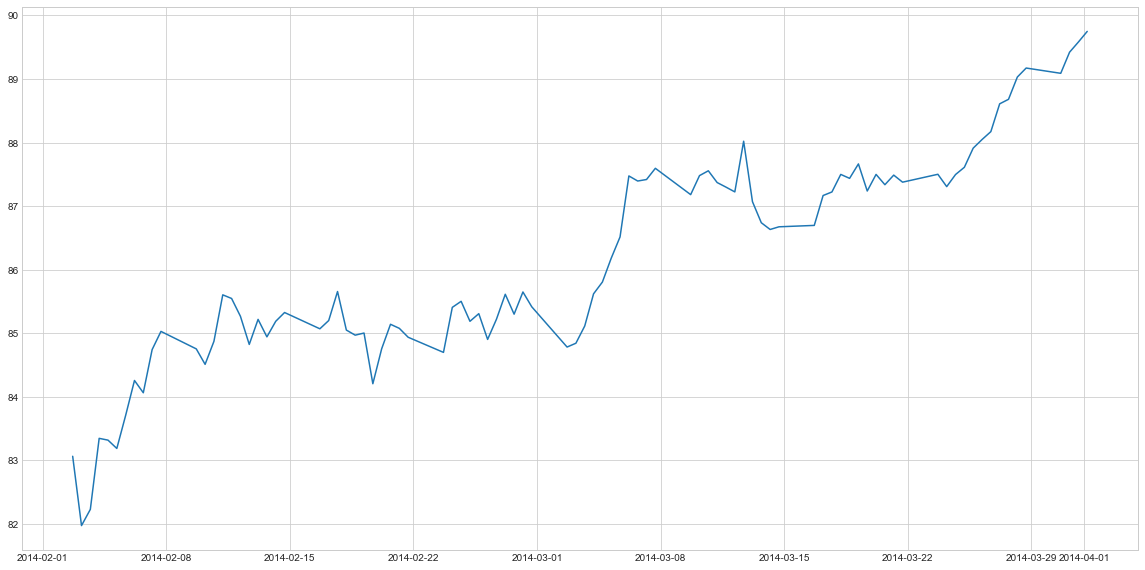

In [4]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()

ax.plot(datetimes, close_prices)

# Smoothing the data
We see that there is noise that will affect our linear regression attempt, so some kind of smoothing will be necessary. One simple possibility is to use the rolling average, which basically will consist on taking a window size of k at a time and perform the average on it.

## Using the rolling average
Let's use in this case a window size (k) of 12 candles for calculating the rolling average:

First, let's create a dataframe with the `datetimes` and `close_prices`:

In [5]:
d = {'times': datetimes , 'prices': close_prices}
df = pd.DataFrame(data=d)

Then, we perform the smoothing:

In [6]:
df['prices_norm']=df[['prices']].rolling(30).mean()

And if we plot the smoothed prices:

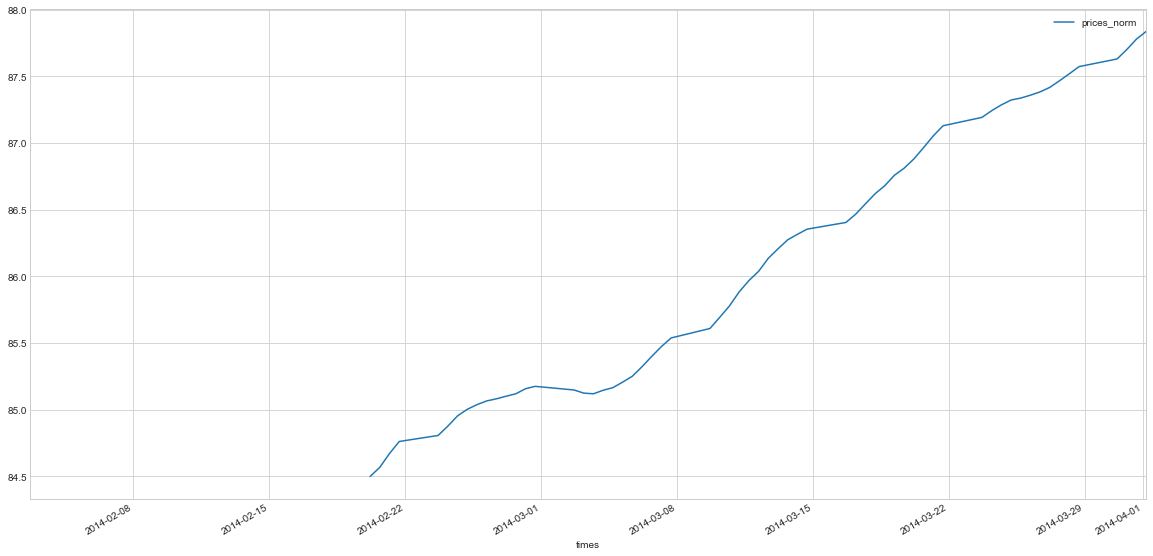

In [7]:
ax = df.plot(x='times', y='prices_norm',figsize=(20, 10))

# Linear regression
We will use `LinearRegression` from `sklearn` for this task. First, let's fit a regression line on the unsmoothed data

## Using the unsmoothed data

In [8]:
model = LinearRegression(fit_intercept=True)

model.fit(np.array(df['times']).reshape(-1,1), np.array(df['prices']).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

And then we predict the prices using the fitted model:

In [9]:
y_pred = model.predict(np.array(df['times'].astype(int)).reshape(-1,1))

Now let's plot the unsmoothed data points and the fitted line

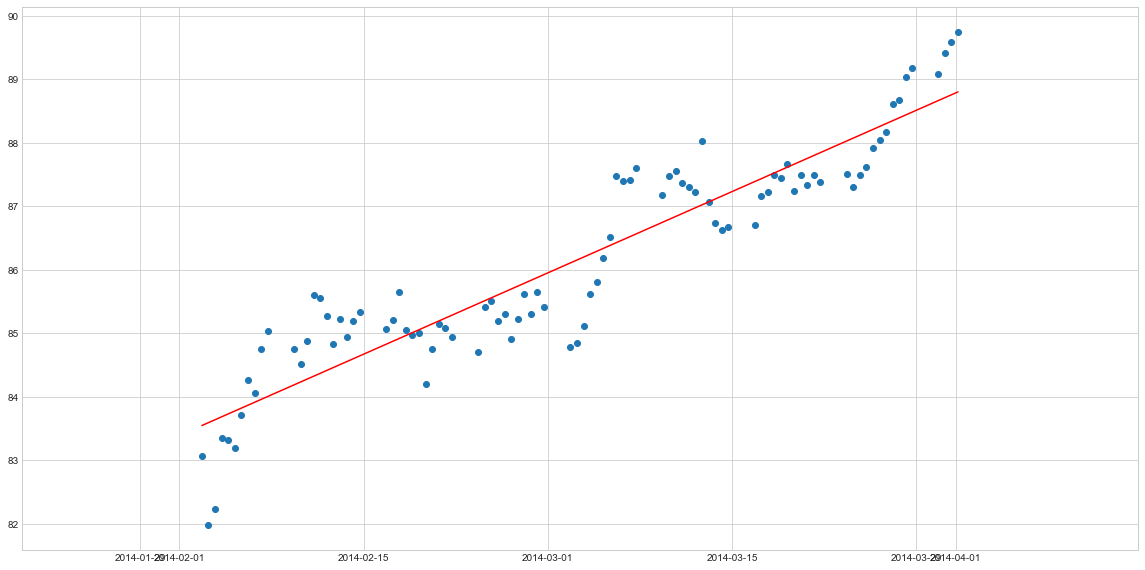

In [10]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(df['times'], df['prices'])
plt.plot(df['times'], y_pred, color='red')

Let's evaluate how good is the model by calculating the `Mean Squared Error` by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. The lower this value the better is the fit

In [11]:
from sklearn.metrics import mean_squared_error

regression_model_mse = mean_squared_error(y_pred, np.array(df['prices_norm']).astype(int).reshape(-1,1))

regression_model_mse

2.681573000192178e+37

## Using the smoothed data

The `prices_norm` variable calculated using the rolling average of `prices` will not have the average for the first window defined and therefore, needs to be removed. For this we do the following:

In [12]:
df=df.dropna()

In [13]:
model = LinearRegression(fit_intercept=True)

model.fit(np.array(df['times']).reshape(-1,1), np.array(df['prices_norm']).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

And then we predict the prices using the fitted model:

In [14]:
y_pred = model.predict(np.array(df['times'].astype(int)).reshape(-1,1))

Now let's plot the unsmoothed data points and the fitted line

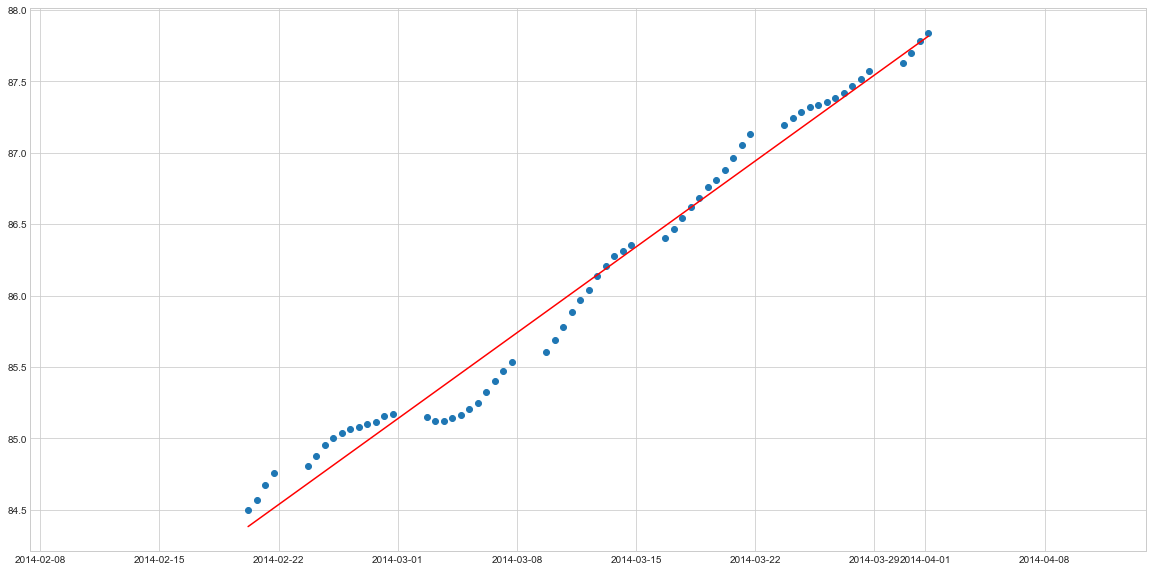

In [15]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(df['times'], df['prices_norm'])
plt.plot(df['times'], y_pred, color='red')

Evaluation of the model:

In [16]:
from sklearn.metrics import mean_squared_error

regression_model_mse = mean_squared_error(y_pred, np.array(df['prices_norm']).astype(int).reshape(-1,1))

regression_model_mse

0.2856763767801222

The model built with the smoothed data has a score that is smaller, which means basically that is better

### Getting the coefficients and intercep

In [17]:
m=model.coef_[0]
b=model.intercept_
print("slope=",m, "intercept=",b)

slope= [9.94737268e-16] intercept= [-1301.16010902]
